# 데이터

In [49]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from itertools import combinations
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

from keras.utils.vis_utils import plot_model

In [50]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

In [51]:
train_data = pd.read_csv('/aiffel/aiffel/dlthon-minions/share/data/train.csv')
train_data.shape

(3950, 3)

In [52]:
additional_train_data = pd.read_csv('/aiffel/aiffel/dlthon-minions/share/data/additional_train.csv')
additional_train_data.shape

(1005, 3)

In [53]:
additional_train_data.sample(10)

,idx,conversation,class
877,877,잘 있었는가 아직 저녁 식사 안하셨지예?\n잘 있었나 방금 어머니 아버지랑 저녁 먹...,일상 대화
748,748,남자 친구 군대 복무기간은 몇 개월 이였어 ?\n2년이엇던 거 같은데 하하?\n군대...,일상 대화
209,209,형은 기억나는 선생님 계시나?\n어 키키 영어 선생님 키키 하도 혼나서 기억난다\n...,일상 대화
157,157,와 스타벅스 난리났네 지금\n왜왜? 아 그 행사 때문에 직원들 항의하는거?\n엉 진...,일상 대화
790,790,오늘 우리 강아지 친구 집에 놀러 왔어 키키\n아 정말요 하하\n강아지가 엄청 좋아...,일상 대화
27,27,처형 치질 수술하신다면서요?\n민망하게 ㅋ\n아무래도 더 늦기 전에\n저도 치질 수...,일상 대화
274,274,너 요즘 나 혼자 산다 보고 있어?\n아니요\n예전에는 봤는데 요새는 안 보네요 키...,일상 대화
270,270,대중교통 이용 잘 하는편이야 ?\n보통 버스 마니 타는거 같애~\n버스정류장은 근처...,일상 대화
80,80,너 요즘 그것이 알고 싶다 프로그램 봐?\n나는 그거 맨날 보는 프로그램이야\n진짜...,일상 대화
716,716,나 오늘 군대에서 제설 했어 키키!\n응? 벌써 제설을 했다고?\n응 눈이 너무 많...,일상 대화


In [54]:
additional_train_data = additional_train_data[['idx', 'class', 'conversation']]
additional_train_data.columns

Index(['idx', 'class', 'conversation'], dtype='object')

In [55]:
train_data = pd.concat([train_data, additional_train_data], ignore_index=True)
train_data.shape

(4955, 3)

In [56]:
train_data = train_data.sample(frac=1, random_state=1).reset_index(drop=True)

In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4955 entries, 0 to 4954
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4955 non-null   int64 
 1   class         4955 non-null   object
 2   conversation  4955 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.3+ KB


## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [58]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [59]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 'class' column 라벨 인코딩

In [60]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일상 대화': 4
}

# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

# 기존 idx, class 컬럼 삭제하기
train_data = train_data.drop(['idx', 'class'], axis=1)

### 텍스트 전처리

#### 한글 외 문자 삭제
- 한글, '?', '!', '.', '.', 공백 유지
- 대화 순서 나타내는 '1: ', '2: ',... 지우기

In [61]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [62]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

0       야 이게 뭐냐 ?  드 드론 .  드 드드 드론 .  새끼 말 더듬는 거 봐 .  ...
1       너 죽여버린다 .   잘못했어요 .  살려주세요 .   뭘 살려줘 .  이 칼로 찔...
2       너는 왜 못생겼어 ?  응 ?  너는 왜 못생겼나구 너무 신기하다 인생 그렇게 살지...
3       이 동네에서 직방 켜봤더니 집이 없네 키키 이 동네는 방이 있겠나 .  .  .  ...
4       아 여성분들이 모여계시네 .  여기 뭐하는 모임입니까 ?  왜 그러시는데요 ?  아...
                              ...                        
4950    왜 돈 안갚아 ?  죄송해요 이번달까지만 기다려주세요 .  나 그렇게 한가한 사람 ...
4951    너 지금 어디야  ?   그걸 왜 궁금해하시죠 ?   너 에 올린글 다봤어 기분 더...
4952    너 좋은 게임기로 논다 ?  이번에 엄마가 생일선물로 사줬어요 .  아 진짜 ?  ...
4953    직장생활은 할만하나 ?  키키 난 집에  있으니까 직장생활이라고 할 게 없네 그렇죠...
4954    야 니네아빠 전과자라며 ?  ?  어떻게 알았어 ?  ?  그게 중요해 ?  니네아...
Name: preprocessed, Length: 4955, dtype: object

In [63]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,야 이게 뭐냐 ? 드 드론 . 드 드드 드론 . 새끼 말 더듬는 거 봐 . ...,1
1,너 죽여버린다 . 잘못했어요 . 살려주세요 . 뭘 살려줘 . 이 칼로 찔...,0
2,너는 왜 못생겼어 ? 응 ? 너는 왜 못생겼나구 너무 신기하다 인생 그렇게 살지...,3
3,이 동네에서 직방 켜봤더니 집이 없네 키키 이 동네는 방이 있겠나 . . . ...,4
4,아 여성분들이 모여계시네 . 여기 뭐하는 모임입니까 ? 왜 그러시는데요 ? 아...,3
...,...,...
4950,왜 돈 안갚아 ? 죄송해요 이번달까지만 기다려주세요 . 나 그렇게 한가한 사람 ...,0
4951,너 지금 어디야 ? 그걸 왜 궁금해하시죠 ? 너 에 올린글 다봤어 기분 더...,0
4952,너 좋은 게임기로 논다 ? 이번에 엄마가 생일선물로 사줬어요 . 아 진짜 ? ...,1
4953,직장생활은 할만하나 ? 키키 난 집에 있으니까 직장생활이라고 할 게 없네 그렇죠...,4


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [64]:
# 불용어 리스트 불러오기
stopwords_path = "/aiffel/aiffel/dlthon-minions/share/preprocess/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install konlpy```

In [65]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

Okt 토크나이저 활용

In [66]:
# Okt로 토큰화
tokenizer=Okt()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))
tokenized_df = train_data[['type', 'tokenized']]

In [67]:
# vocabulary 파일로 저장
def save_vocab(tokenized, vocab_path):
    # 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
    all_tokens = [token for tokens in tokenized for token in tokens]
    counter = Counter(all_tokens)
    # 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
    counter = counter.most_common(VOCAB_SIZE)
    
    with open(vocab_path, 'w') as f:
        f.write("<pad>: 0\n")
        f.write("<unk>: 1\n")
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx+2}\n"
            f.write(line)
            
vocab_path = '/aiffel/aiffel/dlthon-minions/share/preprocess/additional_vocab.txt'
save_vocab(train_data['tokenized'], vocab_path)

#### 단어사전 생성

In [68]:
def create_word_to_index(vocab_path):
    # 인코딩에 활용할 단어사전 딕셔너리 생성
    word_to_index = {}
    with open(vocab_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            tmp = line.split(": ")
            word = tmp[0]
            idx = int(tmp[1])
            word_to_index.update({word: idx})
    return word_to_index

In [69]:
word_to_index=create_word_to_index(vocab_path)
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 '!': 4,
 '내': 5,
 '는': 6,
 '은': 7,
 '말': 8,
 '진짜': 9,
 '다': 10,
 '뭐': 11,
 '돈': 12,
 '만': 13,
 '잘': 14,
 '해': 15,
 '니': 16,
 '한': 17,
 '요': 18,
 '지금': 19,
 '게': 20,
 '고': 21,
 '죄송합니다': 22,
 '하고': 23,
 '한테': 24,
 '그냥': 25,
 '이야': 26,
 '할': 27,
 '더': 28,
 '너무': 29,
 '하는': 30,
 'ㅠㅠ': 31,
 '님': 32,
 '나도': 33,
 '지': 34,
 '랑': 35,
 '집': 36,
 '생각': 37,
 '그런': 38,
 '알': 39,
 '오늘': 40,
 '난': 41,
 '하면': 42,
 '그렇게': 43,
 '제발': 44,
 '많이': 45,
 '수': 46,
 '있어': 47,
 '맞아': 48,
 '애': 49,
 '친구': 50,
 '돼': 51,
 '면': 52,
 '정말': 53,
 '없어': 54,
 '아니야': 55,
 '그거': 56,
 '줄': 57,
 '그건': 58,
 '한번': 59,
 '엄마': 60,
 '빨리': 61,
 '요즘': 62,
 '인데': 63,
 '새끼': 64,
 '그게': 65,
 '해서': 66,
 '씨': 67,
 '서': 68,
 '회사': 69,
 'ㅜㅜ': 70,
 '이제': 71,
 '이렇게': 72,
 '전': 73,
 '거야': 74,
 '같아': 75,
 '하지': 76,
 '라고': 77,
 '넌': 78,
 '걸': 79,
 '적': 80,
 '니까': 81,
 '이랑': 82,
 '라': 83,
 '있는': 84,
 '보고': 85,
 '대리': 86,
 '같은': 87,
 '일이': 88,
 '뭘': 89,
 '만원': 90,
 '건': 91,
 '소리': 92,
 '살': 93,
 '했어'

#### 정수인코딩

In [70]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

tokenized_df['encoded'] = tokenized_df['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

/tmp/ipykernel_10109/1106553519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_df['encoded'] = tokenized_df['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))


In [71]:
tokenized_df.head()

,type,tokenized,encoded
0,1,"[게, 뭐, 냐, ?, 드, 드론, ., 드, 드드, 드론, ., 새끼, 말, 더듬...","[20, 11, 151, 3, 2573, 11399, 2, 2573, 16929, ..."
1,0,"[죽여, 버린다, ., 잘, ., 살려주세요, ., 뭘, 살려줘, ., 칼, 찔러,...","[157, 676, 2, 14, 2, 275, 2, 89, 834, 2, 242, ..."
2,3,"[는, 생겼어, ?, ?, 는, 생겼나구, 너무, 신기하다, 인생, 그렇게, 살지마...","[6, 1240, 3, 3, 6, 16932, 29, 2040, 463, 43, 4..."
3,4,"[동네, 직방, 켜, 봤더니, 집, 없네, 동네, 는, 방이, 있겠나, ., ., ...","[691, 6257, 3483, 11401, 36, 371, 691, 6, 5467..."
4,3,"[여성, 분들, 모여계시네, ., 뭐, 하는, 모임, 입, 니까, ?, 그러시는데요...","[2878, 1266, 16946, 2, 11, 30, 2577, 254, 81, ..."


## 전처리 후 분석

#### 패딩 적용

In [72]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [73]:
X = pad_sequences(tokenized_df['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [74]:
y = tokenized_df['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3964
훈련 레이블의 개수 : 3964
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 496
테스트 레이블의 개수 : 496


In [75]:
# 테스트 데이터셋 클래스 불균형 확인
counter = Counter(y_train)
counter.most_common()

[(3, 869), (4, 811), (1, 798), (2, 783), (0, 703)]

# 모델링

In [76]:
!pip install wandb==0.16.0

In [77]:
import wandb

key='809618c39f10bc0019fd6fd710cb28c698c30197'
wandb.login(key = key)

wandb: Currently logged in as: 4rldur0 (4-rldur0). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [78]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "values": [0.03447]
            },
        "epoch" : {
            "values": [8]
            },
        "batch_size": {
            "values": [16]
            },
        "optimizer": {
            "values": ["adam"]
            },
        "dropout_rate":{
            "values": [0.1]
            }
        }
    }

default_config = {
        "vocab" : VOCAB_SIZE,
        "embeddings" : 128,
        "units_128" : 128,
        "units_256" : 256,
        "units_512" : 512,
        "units_1024" : 1024,
        "units_2048" : 2048,
        "kernel_3" : 3,
        "kernel_5" : 5,
        "class_num" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
    }

In [79]:
def build_model_baseline(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_256, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_512))
    model.add(keras.layers.Dense(config.units_1024, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))  
    return model

In [80]:
def build_model_1DCNN(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(config.units_128, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax')) 
    return model

In [81]:
def build_model_1DCNN_GRU(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.SpatialDropout1D(config.dropout_rate))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GRU(config.units_128, dropout=config.dropout_rate, recurrent_dropout=config.dropout_rate))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))
    return model

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import wandb

# heatmap으로 비교 결과를 그려주는 함수
def plot_table(cm):
    title = "Overall Prediction Result"
    # 실제 클래스명으로 변환
    classes = [
        '협박 대화',
        '갈취 대화',
        '직장 내 괴롭힘 대화',
        '기타 괴롭힘 대화',
        '일반 대화'
    ]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={'size': 30})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    return plt

# epoch이 모두 끝나면 각 클래스별 GT와 예측값을 비교한 표 시각화
# 5x5의 표의 [i,j]의 위치는 실제값은 i번째 클래스이고, 예측값은 j번째 클래스임을 나타냄
class CompareResultsCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, class_num):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.class_num = class_num
        # 전체 표 초기화
        self.table = np.zeros((self.class_num, self.class_num), dtype=np.int32)

    def on_train_end(self, epoch, logs=None):
        # 마지막 epoch에서만 계산
        pred_test = self.model.predict(self.X_test).argmax(axis=1)
        self.y_test = np.array(self.y_test)
        pred_test = np.array(pred_test)
            
        # 5개의 클래스에서 두 개씩 뽑아내어 비교
        # 실제값이 class_a일 때, 예측값을 claas_b로 예측한 횟수
        for class_a in range(self.class_num):
            for class_b in range(self.class_num):
                num = len(np.where((self.y_test == class_a) & (pred_test == class_b))[0])
                self.table[class_a, class_b] += num

        # 표 그리기
        cr_plot = plot_table(self.table)
            
        # wandb에 로그로 저장
        cr_image = wandb.Image(cr_plot)
        wandb.log({"Overall Prediction Result": cr_image})


In [83]:
# 학습 함수 정의
# CompareResultsCallback 테스트 데이터셋을 활용하므로 인자로 넣어줌
def train(default_config, X_test, y_test):

    wandb.init(config = default_config)
    config = wandb.config
    
    keras.backend.clear_session()

    # Model
    model = build_model_1DCNN(config)

    # Compile
    model.compile(optimizer = config.optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # 비교 결과 그리는 콜백
    cr_callback = CompareResultsCallback(X_test, y_test, config.class_num)
    # earlystopping 콜백
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    
    # 학습
    history = model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks=[wandb.keras.WandbCallback(), cr_callback, es_callback])
    
    # test dataset으로 accuracy 계산    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    pred_test = model.predict(X_test).argmax(axis=1)
    # test dataset으로 f1 score 계산
    f1_score_res = f1_score(y_test, pred_test, average='micro')

    # wandb에 log 추가
    wandb.log({
        "Test Accuracy Rate": test_accuracy,
        "Test F1 Score": f1_score_res,
        "Test Error Rate": 1 - test_accuracy
    })
    
    return history

Create sweep with ID: fwbnwgrt
Sweep URL: https://wandb.ai/aiffel_minions/DLthon_CNN_Additional_data/sweeps/fwbnwgrt


wandb: Agent Starting Run: c655jbtu with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epoch: 8
wandb: 	learning_rate: 0.03447
wandb: 	optimizer: adam
wandb: Currently logged in as: 4rldur0 (aiffel_minions). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/8
248/248 [==============================] - 5s 7ms/step - loss: 1.0024 - accuracy: 0.5956 - val_loss: 0.4766 - val_accuracy: 0.8343
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_033035-c655jbtu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_033035-c655jbtu/files/model-best)... Done. 0.1s


Epoch 2/8
248/248 [==============================] - 1s 5ms/step - loss: 0.2791 - accuracy: 0.9067 - val_loss: 0.3472 - val_accuracy: 0.8707
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_033035-c655jbtu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_033035-c655jbtu/files/model-best)... Done. 0.1s


Epoch 3/8
248/248 [==============================] - 1s 5ms/step - loss: 0.0364 - accuracy: 0.9937 - val_loss: 0.3288 - val_accuracy: 0.8869
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_033035-c655jbtu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_033035-c655jbtu/files/model-best)... Done. 0.1s


Epoch 4/8
248/248 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.3403 - val_accuracy: 0.8788
Epoch 5/8
248/248 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3536 - val_accuracy: 0.8808
16/16 - 0s - loss: 0.3572 - accuracy: 0.8972


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▆███
epoch,▁▃▅▆█
loss,█▃▁▁▁
val_accuracy,▁▆█▇▇
val_loss,█▂▁▂▂
Test Accuracy Rate,0.89718
Test Error Rate,0.10282
Test F1 Score,0.89718


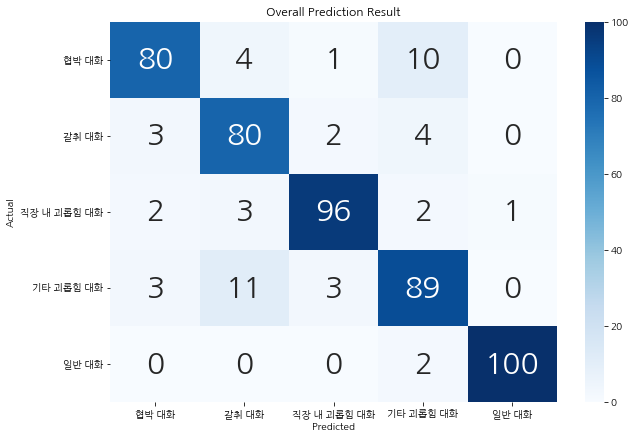

In [84]:
# train()에 인자가 있으므로 wrapper function 정의
def sweep_train():
    train(default_config=default_config, X_test=X_test, y_test=y_test)

# 팀프로젝트 내에서 sweep 실행
sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_minions',
                       project = 'DLthon_CNN_Additional_data')


wandb.agent(sweep_id,
            function=sweep_train,
            count=1)